### Gloden cross strategy

In [19]:
import time
from datetime import datetime
import vectorbt as vbt

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

### import csv

In [117]:
data = pd.read_csv('USDJPY_15m.csv')
data.tail()

timestamp        open        high         low  \
7832  2022-03-01 15:45:00+00:00  114.797997  114.849998  114.720001   
7833  2022-03-01 16:00:00+00:00  114.802002  114.912003  114.760002   
7834  2022-03-01 16:15:00+00:00  114.910004  114.919998  114.830002   
7835  2022-03-01 16:30:00+00:00  114.903999  114.925003  114.760002   
7836  2022-03-01 16:45:00+00:00  114.850998  114.912003  114.809998   

           close   adj close  volumn  
7832  114.800003  114.800003       0  
7833  114.912003  114.912003       0  
7834  114.903000  114.903000       0  
7835  114.848000  114.848000       0  
7836  114.889999  114.889999       0

In [118]:
df = data.copy()

### Create strategy

In [22]:
gloden_cross = ta.Strategy(
    name = 'Gloden cross',
    description = 'Gloden cross by EMA 2 Line',
    ta = [
        {'kind': 'ema', 'length': 200},
        {'kind': 'ema', 'length': 10},
        {'kind': 'ema', 'length': 50}
    ]
)
df.ta.strategy(gloden_cross)

### Create signal

In [115]:
class BacktestGlodenCross:
    def __init__(self, params):
        self.orders = pd.DataFrame(columns = ['action', 'open time', 'open', 'close time', 'close', 'T/P', 'S/L', 'result'])
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        self.unknow_result = []
        
        self.current_action = 'close'
        self.atr_len = params['atr_len']
        self.ema_1 = params['ema_1']
        self.ema_2 = params['ema_2']
        
        self.pip_value = params['pip_value']
        self.rr = params['rr']
        self.df = params['df']
        self.plot = params['plot']
        
    def reset_order(self):
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        
    def get_df(self):
        return self.df
        
    def plot_order(self, order):
        df = self.df.copy()
        df.set_index('timestamp', inplace = True)
        data_plot = df.loc[order['open time']:order['close time']]
        
        entry_line = np.empty(data_plot.shape[0])
        entry_line.fill(order['open'])

        tp_line = np.empty(data_plot.shape[0])
        tp_line.fill(order['T/P'])

        sl_line = np.empty(data_plot.shape[0])
        sl_line.fill(order['S/L'])

        ema_line1 = data_plot['EMA_'+str(self.ema_1)]
        ema_line2 = data_plot['EMA_'+str(self.ema_2)]
        ema_len_line = data_plot['EMA_200']
        
        ema1_plot = mpf.make_addplot(ema_line1, panel=0, color='blue', width=1.5)
        ema2_plot = mpf.make_addplot(ema_line2, panel=0, color='hotpink', width=1.5)
        ema_len_plot = mpf.make_addplot(ema_len_line, panel=0, color='gray', width=1.5)

        entry_plot = mpf.make_addplot(entry_line, panel=0, color='blue', width=1.5)
        tp_plot = mpf.make_addplot(tp_line, panel=0, color='green', linestyle = 'dashed', width=1)
        sl_plot = mpf.make_addplot(sl_line, panel=0, color='red', linestyle = 'dotted', width=2)
        
        mpf.plot(data_plot, 
                 type='candle', 
                 style='charles', 
                 addplot=[ema1_plot, ema2_plot, ema_len_plot, entry_plot, tp_plot, sl_plot], 
                 figsize=(8, 4))
        
    def backtest(self):
        n_bars = 3
        gloden_cross = ta.Strategy(
            name = 'Gloden cross',
            description = 'Gloden cross by EMA 2 Line',
            ta = [
                {'kind': 'ema', 'length': 200},
                {'kind': 'ema', 'length': self.ema_1},
                {'kind': 'ema', 'length': self.ema_2},
                {'kind': 'atr', 'length': self.atr_len}
            ]
        )
        self.df.ta.strategy(gloden_cross)
        self.df = self.df.copy().dropna()
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['action'] = None
        
        self.df['entries'] = False
        self.df['exits'] = False
        self.df['short_entries'] = False
        self.df['short_exits'] = False
        
        for index, row in self.df.iterrows():
            entry = 0
            
            if self.current_action == 'close':
            
                if (row['EMA_'+str(self.ema_1)] > row['EMA_'+str(self.ema_2)]) and (row['low'] > row['EMA_'+str(200)]):
                    # check if previous n bars ema_1 < ema_2 then buy.
                    if index > n_bars:
                        for pre_index, pre_row in self.df.iloc[index-n_bars:index].iterrows():
                            if (pre_row['EMA_'+str(self.ema_1)] < pre_row['EMA_'+str(self.ema_2)]):
                                self.df.at[index, 'action'] = 'buy'
                                self.df.at[index, 'entries'] = True
                                self.order['action'] = 'buy'
                                self.order['open time'] = row['timestamp']
                                self.order['open'] = row['open']
                                self.order['S/L'] = row['open'] - row['ATRr_'+str(self.atr_len)]
                                self.order['T/P'] = row['open'] + (self.rr * abs(row['open'] - self.order['S/L']))
                                self.current_action = 'buy'
                        
                elif (row['EMA_'+str(self.ema_1)] < row['EMA_'+str(self.ema_2)]) and (row['high'] < row['EMA_'+str(200)]):
                    # check if previous n bars ema_1 > ema_2 then sell.
                    if index > n_bars:
                        for pre_index, pre_row in self.df.iloc[index-n_bars:index].iterrows():
                            if (pre_row['EMA_'+str(self.ema_1)] > pre_row['EMA_'+str(self.ema_2)]):
                                self.df.at[index, 'action'] = 'sell'
                                self.df.at[index, 'short_entries'] = True
                                self.order['action'] = 'sell'
                                self.order['open time'] = row['timestamp']
                                self.order['open'] = row['open']
                                self.order['S/L'] = row['open'] + row['ATRr_'+str(self.atr_len)]
                                self.order['T/P'] = row['open'] - (self.rr * abs(row['open'] - self.order['S/L']))
                                self.current_action = 'sell'
        
            if self.current_action == 'buy':
                if row['low'] <= self.order['S/L'] and row['high'] >= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['low'] <= self.order['S/L']:
                    self.df.at[index, 'exits'] = True
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()
                    
                elif row['high'] >= self.order['T/P']:
                    self.df.at[index, 'exits'] = True
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()

            elif self.current_action == 'sell':
                if row['high'] >= self.order['S/L'] and row['low'] <= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['high'] >= self.order['S/L']:
                    self.df.at[index, 'short_exits'] = True
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()
                    
                elif row['low'] <= self.order['T/P']:
                    self.df.at[index, 'short_exits'] = True
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()

        try:
            win_rate = round(len(self.orders[self.orders['result'] == 'T/P']) * 100 / len(self.orders), 2)
            loss_rate = round(len(self.orders[self.orders['result'] == 'S/L']) * 100 / len(self.orders), 2)

            win_orders = int((win_rate * len(self.orders)) / 100 )
            loss_orders = len(self.orders) - win_orders
            gain = (win_orders * self.rr) - loss_orders

            result_info = f"total orders: {len(self.orders)}\nema_1: {self.ema_1}, ema_2: {self.ema_2}, atr: {self.atr_len}, gain: {gain}\n"
            return {'win_rate': win_rate, 'info': result_info, 'total_order': len(self.orders), 'rr': self.rr, 'gain': gain, 'unknow': self.unknow_result}
        except:
    #         print("No orders to action")
            return {'win_rate': 0, 'info': 'No orders to action'}

In [126]:
pair_test = BacktestGlodenCross({
    'atr_len': 14,
    'ema_1': 14,
    'ema_2': 64,
    'pip_value': 0.001,
    'rr': 1.5,
    'plot': False,
    'df': df.copy()
})
pair_test.backtest()

{'win_rate': 41.47,
 'info': 'total orders: 504\nema_1: 14, ema_2: 64, atr: 14, gain: 18.5\n',
 'total_order': 504,
 'rr': 1.5,
 'gain': 18.5,
 'unknow': [timestamp        2022-02-10 09:00:00+00:00
  open                            115.561996
  high                            115.842003
  low                             115.510002
  close                              115.819
  adj close                          115.819
  volumn                                   0
  EMA_200                         115.461161
  EMA_14                          115.637245
  EMA_64                           115.56592
  ATRr_14                           0.095427
  action                                None
  entries                              False
  exits                                False
  short_entries                        False
  short_exits                          False
  Name: 6581, dtype: object]}

In [127]:
pair_df = pair_test.get_df().copy()
pair_df

timestamp        open        high         low  \
199  2021-11-08 21:30:00+00:00  113.230003  113.242996  113.190002   
200  2021-11-08 21:45:00+00:00  113.222000  113.231003  113.180000   
201  2021-11-08 22:00:00+00:00  113.207001  113.239998  113.181000   
202  2021-11-08 22:15:00+00:00  113.205002  113.239998  113.188004   
203  2021-11-08 22:30:00+00:00  113.223999  113.250000  113.204002   
...                        ...         ...         ...         ...   
7832 2022-03-01 15:45:00+00:00  114.797997  114.849998  114.720001   
7833 2022-03-01 16:00:00+00:00  114.802002  114.912003  114.760002   
7834 2022-03-01 16:15:00+00:00  114.910004  114.919998  114.830002   
7835 2022-03-01 16:30:00+00:00  114.903999  114.925003  114.760002   
7836 2022-03-01 16:45:00+00:00  114.850998  114.912003  114.809998   

           close   adj close  volumn     EMA_200      EMA_14      EMA_64  \
199   113.220001  113.220001       0  113.548915  113.226727  113.316561   
200   113.230003  113.230003       0  113.545742  113.227164  113.313898   
201   113.204002  113.204002       0  113.542342  113.224075  113.310517   
202   113.239998  113.239998       0  113.539333  113.226198  113.308347   
203   113.230003  113.230003       0  113.536255  113.226706  113.305936   
...          ...         ...     ...         ...         ...         ...   
7832  114.800003  114.800003       0  115.134877  114.846968  114.953208   
7833  114.912003  114.912003       0  115.132660  114.855639  114.951940   
7834  114.903000  114.903000       0  115.130375  114.861954  114.950434   
7835  114.848000  114.848000       0  115.127565  114.860093  114.947282   
7836  114.889999  114.889999       0  115.125201  114.864081  114.945520   

       ATRr_14 action  entries  exits  short_entries  short_exits  
199   0.071221   sell    False  False           True        False  
200   0.069777   None    False  False          False        False  
201   0.069007   None    False  False          False        False  
202   0.067792   None    False  False          False        False  
203   0.066235   None    False  False          False        False  
...        ...    ...      ...    ...            ...          ...  
7832  0.114133   None    False  False          False        False  
7833  0.116838   None    False  False          False        False  
7834  0.114920   None    False  False          False        False  
7835  0.118498   None    False  False          False        False  
7836  0.117320   None    False  False          False        False  

[7638 rows x 16 columns]

In [128]:
pair_df['timestamp'] = pd.to_datetime(pair_df['timestamp'], unit='ms')
pair_df = pair_df.set_index('timestamp')
pair_df

open        high         low       close  \
timestamp                                                                   
2021-11-08 21:30:00+00:00  113.230003  113.242996  113.190002  113.220001   
2021-11-08 21:45:00+00:00  113.222000  113.231003  113.180000  113.230003   
2021-11-08 22:00:00+00:00  113.207001  113.239998  113.181000  113.204002   
2021-11-08 22:15:00+00:00  113.205002  113.239998  113.188004  113.239998   
2021-11-08 22:30:00+00:00  113.223999  113.250000  113.204002  113.230003   
...                               ...         ...         ...         ...   
2022-03-01 15:45:00+00:00  114.797997  114.849998  114.720001  114.800003   
2022-03-01 16:00:00+00:00  114.802002  114.912003  114.760002  114.912003   
2022-03-01 16:15:00+00:00  114.910004  114.919998  114.830002  114.903000   
2022-03-01 16:30:00+00:00  114.903999  114.925003  114.760002  114.848000   
2022-03-01 16:45:00+00:00  114.850998  114.912003  114.809998  114.889999   

                            adj close  volumn     EMA_200      EMA_14  \
timestamp                                                               
2021-11-08 21:30:00+00:00  113.220001       0  113.548915  113.226727   
2021-11-08 21:45:00+00:00  113.230003       0  113.545742  113.227164   
2021-11-08 22:00:00+00:00  113.204002       0  113.542342  113.224075   
2021-11-08 22:15:00+00:00  113.239998       0  113.539333  113.226198   
2021-11-08 22:30:00+00:00  113.230003       0  113.536255  113.226706   
...                               ...     ...         ...         ...   
2022-03-01 15:45:00+00:00  114.800003       0  115.134877  114.846968   
2022-03-01 16:00:00+00:00  114.912003       0  115.132660  114.855639   
2022-03-01 16:15:00+00:00  114.903000       0  115.130375  114.861954   
2022-03-01 16:30:00+00:00  114.848000       0  115.127565  114.860093   
2022-03-01 16:45:00+00:00  114.889999       0  115.125201  114.864081   

                               EMA_64   ATRr_14 action  entries  exits  \
timestamp                                                                
2021-11-08 21:30:00+00:00  113.316561  0.071221   sell    False  False   
2021-11-08 21:45:00+00:00  113.313898  0.069777   None    False  False   
2021-11-08 22:00:00+00:00  113.310517  0.069007   None    False  False   
2021-11-08 22:15:00+00:00  113.308347  0.067792   None    False  False   
2021-11-08 22:30:00+00:00  113.305936  0.066235   None    False  False   
...                               ...       ...    ...      ...    ...   
2022-03-01 15:45:00+00:00  114.953208  0.114133   None    False  False   
2022-03-01 16:00:00+00:00  114.951940  0.116838   None    False  False   
2022-03-01 16:15:00+00:00  114.950434  0.114920   None    False  False   
2022-03-01 16:30:00+00:00  114.947282  0.118498   None    False  False   
2022-03-01 16:45:00+00:00  114.945520  0.117320   None    False  False   

                           short_entries  short_exits  
timestamp                                              
2021-11-08 21:30:00+00:00           True        False  
2021-11-08 21:45:00+00:00          False        False  
2021-11-08 22:00:00+00:00          False        False  
2021-11-08 22:15:00+00:00          False        False  
2021-11-08 22:30:00+00:00          False        False  
...                                  ...          ...  
2022-03-01 15:45:00+00:00          False        False  
2022-03-01 16:00:00+00:00          False        False  
2022-03-01 16:15:00+00:00          False        False  
2022-03-01 16:30:00+00:00          False        False  
2022-03-01 16:45:00+00:00          False        False  

[7638 rows x 15 columns]

In [129]:
pair_df[pair_df['exits'] == True]

open        high         low       close  \
timestamp                                                                   
2021-11-10 12:30:00+00:00  113.247002  113.339996  113.220001  113.289001   
2021-11-10 13:15:00+00:00  113.260002  113.286003  113.185997  113.220001   
2021-11-10 13:30:00+00:00  113.222000  113.492996  113.209999  113.431000   
2021-11-10 13:45:00+00:00  113.436996  113.482002  113.250000  113.444000   
2021-11-10 14:15:00+00:00  113.486000  113.487000  113.330002  113.364998   
...                               ...         ...         ...         ...   
2022-02-25 02:15:00+00:00  115.382004  115.389999  115.250000  115.286003   
2022-02-25 03:30:00+00:00  115.269997  115.277000  115.150002  115.160004   
2022-02-25 09:30:00+00:00  115.276001  115.379997  115.250000  115.346001   
2022-02-25 12:15:00+00:00  115.450996  115.521004  115.419998  115.489998   
2022-02-25 17:00:00+00:00  115.629997  115.669998  115.570000  115.655998   

                            adj close  volumn     EMA_200      EMA_14  \
timestamp                                                               
2021-11-10 12:30:00+00:00  113.289001       0  113.093899  113.196989   
2021-11-10 13:15:00+00:00  113.220001       0  113.098371  113.213187   
2021-11-10 13:30:00+00:00  113.431000       0  113.101681  113.242228   
2021-11-10 13:45:00+00:00  113.444000       0  113.105087  113.269131   
2021-11-10 14:15:00+00:00  113.364998       0  113.111376  113.306396   
...                               ...     ...         ...         ...   
2022-02-25 02:15:00+00:00  115.286003       0  115.110785  115.460073   
2022-02-25 03:30:00+00:00  115.160004       0  115.117922  115.352890   
2022-02-25 09:30:00+00:00  115.346001       0  115.146635  115.285649   
2022-02-25 12:15:00+00:00  115.489998       0  115.173999  115.402623   
2022-02-25 17:00:00+00:00  115.655998       0  115.242281  115.575863   

                               EMA_64   ATRr_14 action  entries  exits  \
timestamp                                                                
2021-11-10 12:30:00+00:00  113.034563  0.083636   None    False   True   
2021-11-10 13:15:00+00:00  113.053389  0.083331   None    False   True   
2021-11-10 13:30:00+00:00  113.065008  0.097593    buy     True   True   
2021-11-10 13:45:00+00:00  113.076669  0.107193    buy     True   True   
2021-11-10 14:15:00+00:00  113.097599  0.112927   None    False   True   
...                               ...       ...    ...      ...    ...   
2022-02-25 02:15:00+00:00  115.327097  0.125966    buy     True   True   
2022-02-25 03:30:00+00:00  115.316826  0.117363   None    False   True   
2022-02-25 09:30:00+00:00  115.285867  0.107230   None    False   True   
2022-02-25 12:15:00+00:00  115.322985  0.097814   None    False   True   
2022-02-25 17:00:00+00:00  115.434208  0.105609   None    False   True   

                           short_entries  short_exits  
timestamp                                              
2021-11-10 12:30:00+00:00          False        False  
2021-11-10 13:15:00+00:00          False        False  
2021-11-10 13:30:00+00:00          False        False  
2021-11-10 13:45:00+00:00          False        False  
2021-11-10 14:15:00+00:00          False        False  
...                                  ...          ...  
2022-02-25 02:15:00+00:00          False        False  
2022-02-25 03:30:00+00:00          False        False  
2022-02-25 09:30:00+00:00          False        False  
2022-02-25 12:15:00+00:00          False        False  
2022-02-25 17:00:00+00:00          False        False  

[243 rows x 15 columns]

In [137]:
port = vbt.Portfolio.from_signals(pair_df.close,
                                  entries=pair_df.entries.astype('bool'),
                                  exits=pair_df.exits.astype('bool'),
                                  short_entries=pair_df.short_entries.astype('bool'),
                                  short_exits=pair_df.short_exits.astype('bool'),
                                  freq="D",
                                  init_cash=100,
                                  fees=0.018,
                                  slippage=0.025
                                 )

In [138]:
port.plot().show()

<AxesSubplot:xlabel='timestamp'>

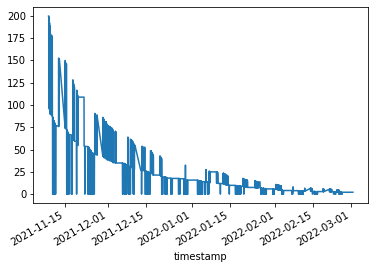

In [136]:
port.cash().plot()

In [95]:
"""
Grid parameter example
line 1: 10 -> 40
line 2: 30 -> 80
condition line 1 < line 2 < line 3
"""
def create_grid_params(line1_start, line1_end, line2_start, line2_end):
    params = []
    for i in range(line1_start, line1_end+1):
        for j in range(line2_start, line2_end+1):
            if( i < j ):
                params.append([i, j])
    return params
params_list = create_grid_params(10, 40, 30, 80)
len(params_list)

1515

In [96]:
good_params = {'win': 0, 'info': ''}
start = 0
end = 1515
win_start = 0

loop_num = start
for param in params_list[start:end]:
    obj = BacktestGlodenCross({'atr_len': 14, 'ema_1': param[0], 'ema_2': param[1], 'pip_value': 0.001, 'rr': 1.5, 'df': df.copy(), 'plot': False})
    result = obj.backtest()
    if result['win_rate'] > win_start and result['total_order'] > 30:
        win_start = result['win_rate']
        good_params['win'] = result['win_rate']
        good_params['info'] = result['info']
    loop_num = loop_num + 1
    print(f"run: {loop_num} to {end}", end = "\r")
    
print(f"\nwin rate: {good_params['win']} %\n{good_params['info']}")

run: 1515 to 1515
win rate: 43.5 %
total orders: 492
ema_1: 12, ema_2: 63, atr: 14, gain: 43.0



#### AUDUSD


#### EURUSD


#### GBPUSD


#### USDJPY

* win rate: 43.5 %
* total orders: 492
* ema_1: 12, ema_2: 63, atr: 14, gain: 43.0

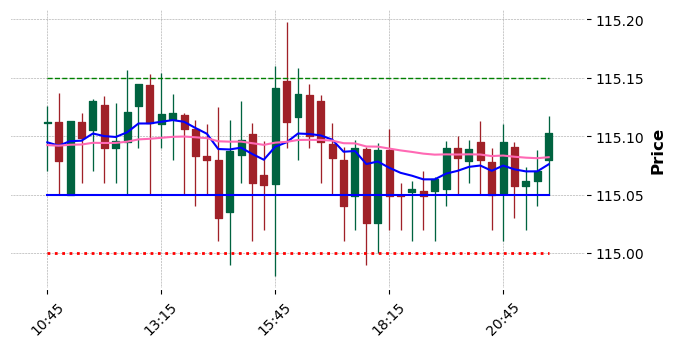

In [78]:
data_test = df.copy()
new_timestamp = data_test['timestamp'].str.split('+', n = 1, expand = True)
data_test['timestamp'] = new_timestamp[0]
data_test['timestamp'] = pd.to_datetime(data_test['timestamp'])
data_test.set_index('timestamp', inplace = True)

ema_line = data_test['EMA_10'].loc['2021-12-31 10:45:00': '2021-12-31 21:45:00']
ema_line2 = data_test['EMA_50'].loc['2021-12-31 10:45:00': '2021-12-31 21:45:00']

data_test_plot = data_test.loc['2021-12-31 10:45:00': '2021-12-31 21:45:00']
entry_line = np.empty(data_test_plot.shape[0])
entry_line.fill(115.05)

tp_line = np.empty(data_test_plot.shape[0])
tp_line.fill(115.15)

sl_line = np.empty(data_test_plot.shape[0])
sl_line.fill(115.00)

ema1_plot = mpf.make_addplot(ema_line, panel=0, color='blue', width=1.5)
ema2_plot = mpf.make_addplot(ema_line2, panel=0, color='hotpink', width=1.5)

entry_plot = mpf.make_addplot(entry_line, panel=0, color='blue', width=1.5)
tp_plot = mpf.make_addplot(tp_line, panel=0, color='green', linestyle = 'dashed', width=1)
sl_plot = mpf.make_addplot(sl_line, panel=0, color='red', linestyle = 'dotted', width=2)

# two_lines = { 'alines': [ema_line, ema_line2], 'colors': ['b', 'g'] }
mpf.plot(data_test_plot, 
         type='candle', style='charles',
         addplot=[ema1_plot, ema2_plot, entry_plot, tp_plot, sl_plot],
         figsize=(8, 4))